## Notebook that takes dihadron ntuples and plots kinematics distributions also with MC

In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time

import seaborn as sns

import root_pandas as rpd
from root_pandas import read_root

#mpl.rcParams['figure.figsize'] = 6.2,3.5
#mpl.rcParams['axes.labelsize'] = 17
#mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['lines.markersize'] = 6
#mpl.rcParams['legend.fontsize']= 13

Welcome to JupyROOT 6.15/01


## Get data

In [2]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print dataframe.shape[0]
    return dataframe
    

In [3]:
df = {}
df_trigger = {}

for target in ['C','Fe','Pb']:
    print 'Getting dataframes from target %s'%target
    df[target]=getdatainChunks('Pairs_%s.root'%target, target)
    df['%s_mix'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_mix'%target)
    df['D_%s'%target]= getdatainChunks('Pairs_%s.root'%target, 'D_%s'%target)
    df['D_%s_mix'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_mix'%target)
    
    print 'Get trigger dataframes from target%s'%target
    df_trigger['%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_trigger'%target)


Getting dataframes from target C
294942
1529559
395135
1983833
Get trigger dataframes from targetC
1218503
1599452
Getting dataframes from target Fe
401683
2201072
715969
3583435
Get trigger dataframes from targetFe
1774824
2886931
Getting dataframes from target Pb
110447
641296
574977
2910316
Get trigger dataframes from targetPb
527766
2349115


## GiBUU

In [4]:
for target in ['D','C','Fe','Pb']:#,'Fe','C']:
    #GiBUU
    print target
    print '----pairs'
    df['GiBUU_%s'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, target)
    print '----trigger'
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, '%s_trigger'%target)

D
----pairs
123368
----trigger
196829
C
----pairs
150219
----trigger
238611
Fe
----pairs
102825
----trigger
166850
Pb
----pairs
89141
----trigger
145708


## Combine deuterium datasets

In [5]:
df['D'] = pd.concat([df['D_Pb'],df['D_Fe'],df['D_C']]) #simply combine the deuterium results for all targets
df['D_mix'] = pd.concat([df['D_Pb_mix'],df['D_Fe_mix'],df['D_C_mix']]) #simply combine the deuterium results for all targets
df_trigger['D_trigger'] = pd.concat([df_trigger['D_Pb_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_C_trigger']]) #simply combine the deuterium results for all targets



In [6]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.140*0.140)', inplace=True)
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'W>2.0', 'W>2.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.5', 'Nu>3.5 :')

    dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyCutsPair(fullDataframe,name='default'):
    print 'Starting election on dipion variables'
    dataframe = fullDataframe
    dataframe.eval('z_tot = z+z_asso', inplace=True)
    dataframe.eval('E_asso = z_asso*Nu', inplace=True)
    dataframe.eval('P_asso = sqrt(E_asso*E_asso-0.140*0.140)', inplace=True)

    dataframe = applyCut(dataframe, 'pid>0 and pid_asso<0', 'Leading p+, subleading pi-')
    dataframe = applyCut(dataframe, 'P_asso>0.100', 'P_asso > 100 MeV')
    dataframe = applyCut(dataframe, 'P_asso<2.5', 'P_asso <2.5 GeV')
    
    return dataframe

def printPairBreakdown(dataframe):
    
    print 'Pairs with Leading pi+', dataframe.query('pid==211').shape[0]
    print 'Pairs with Leading pi-', dataframe.query('pid==-211').shape[0]
    print 'Pairs with Sub-Leading pi+', dataframe.query('pid_asso==211').shape[0]
    print 'Pairs with Sub-Leading pi-', dataframe.query('pid_asso==-211').shape[0]
    print 'pi+ pi+ pairs',dataframe.query('pid==211 and pid_asso==211').shape[0]
    print 'pi- pi- pairs',dataframe.query('pid==-211 and pid_asso==-211').shape[0]
    print 'pi+ pi- pairs',dataframe.query('pid==211 and pid_asso==-211').shape[0]
    print 'pi- pi+ pairs',dataframe.query('pid==-211 and pid_asso==211').shape[0]
    print '//////////////////////////////////////////////////////'
    return 


## apply cuts

In [7]:
for key in df.keys():
    print key
    df[key] = applyCuts(df[key])
    #printPairBreakdown(df[key])
    df[key] = applyCutsPair(df[key])
    print '--------------'
    
for key in df_trigger.keys():
    print key
    df_trigger[key] = applyCuts(df_trigger[key])

C
Entries before cut  294942
Q2>1.0 : 294942  (100.00  %)
W>2.0 : 294933  (100.00  %)
z>0.5 : 133825  (45.37  %)
P<2.5  116832  (87.30  %)
inelasticity < 0.85 113388  (97.05  %)
Starting election on dipion variables
z_asso<1.0 113321  (99.94  %)
z_tot<1.0 112098  (98.92  %)
theta_lab_asso<1.0 (rad) 80189  (71.53  %)
theta_lab <1.0 (rad) 80080  (99.86  %)
--------------
D_Fe_mix
Entries before cut  3583435
Q2>1.0 : 3583435  (100.00  %)
W>2.0 : 3583364  (100.00  %)
z>0.5 : 2088727  (58.29  %)
P<2.5  1686594  (80.75  %)
inelasticity < 0.85 1656632  (98.22  %)
Starting election on dipion variables
z_asso<1.0 1655490  (99.93  %)
z_tot<1.0 1325501  (80.07  %)
theta_lab_asso<1.0 (rad) 1119152  (84.43  %)
theta_lab <1.0 (rad) 1118328  (99.93  %)
--------------
D_mix
Entries before cut  8477584
Q2>1.0 : 8477584  (100.00  %)
W>2.0 : 8477420  (100.00  %)
z>0.5 : 4940185  (58.27  %)
P<2.5  3990104  (80.77  %)
inelasticity < 0.85 3917356  (98.18  %)
Starting election on dipion variables
z_asso<1.0 

Entries before cut  145708
Q2>1.0 : 145708  (100.00  %)
W>2.0 : 145708  (100.00  %)
z>0.5 : 145708  (100.00  %)
P<2.5  77738  (53.35  %)
inelasticity < 0.85 77738  (100.00  %)
GiBUU_D_trigger
Entries before cut  196829
Q2>1.0 : 196829  (100.00  %)
W>2.0 : 196829  (100.00  %)
z>0.5 : 196829  (100.00  %)
P<2.5  101264  (51.45  %)
inelasticity < 0.85 101264  (100.00  %)
D_Fe_trigger
Entries before cut  2886931
Q2>1.0 : 2886931  (100.00  %)
W>2.0 : 2886872  (100.00  %)
z>0.5 : 1682597  (58.28  %)
P<2.5  1358626  (80.75  %)
inelasticity < 0.85 1334445  (98.22  %)
C_trigger
Entries before cut  1218503
Q2>1.0 : 1218503  (100.00  %)
W>2.0 : 1218362  (99.99  %)
z>0.5 : 693456  (56.92  %)
P<2.5  566200  (81.65  %)
inelasticity < 0.85 554306  (97.90  %)


## Event Variables

In [8]:
def plotEventVariables(df):
    fig = plt.figure( figsize=(20, 10))
    plt.subplot(2,3,1)
    plt.hist(df['Nu'], bins=25,range =(2,5), histtype='step', normed=True,label='Data')
    plt.legend()
    plt.xlabel("Nu [GeV]", fontsize=20)

    plt.subplot(2,3,2)
    plt.hist(df['Q2'], bins=25,range =(1,5), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['Q2'], bins=25,range = (1,5),  normed = True,alpha=0.2,label='MC')
    plt.xlabel("$Q^{2} [GeV^{2}]$", fontsize=20)

    #plt.subplot(2,3,3)
    #plt.hist(df['W'], bins=25,range =(1,3), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['W'], bins=25,range = (1,3), normed = True,alpha=0.2,label='MC')
    #plt.xlabel("$W$ [GeV]", fontsize=20)

    plt.subplot(2,3,4)
    plt.hist(df['Xb'], bins=25,range =(0,1), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['Xb'], bins=25,range = (0,1),  normed = True,alpha=0.2,label='MC')
    plt.xlabel("$x$", fontsize=20)
    
    plt.subplot(2,3,5)
    plt.hist(df['inelasticity'], bins=25,range =(0,1), histtype='step', normed=True,label='Data')
    plt.legend()
    plt.xlabel("inelasticity", fontsize=20)
    plt.axvline(x=.850,color='red',linestyle='--')


    #plt.subplot(2,3,5)
    #plt.hist(df['SectorEl'], bins = 12, range = (-0.5,5.5),histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['SectorEl'], bins = 12, range=(-0.5,5.5), normed = True,alpha=0.2,label='MC')
    #plt.xlabel('Sector El')

    #plt.subplot(2,3,6)
    #plt.hist(df['deltaZ'], bins = 100, range=(-50,50), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['deltaZ'], bins = 100, range=(-50,50), normed = True,alpha=0.2,label='MC')
    #plt.xlabel('Delta z')
    #plt.show()
    
    return

## Profile distributions to see correlation with kinematic variables with z2

#### This is accomplished with sns.regplot (seaborn package needed). It plots the average of a quantity in bins o the other quantities. This is more useful than a 2D distribution

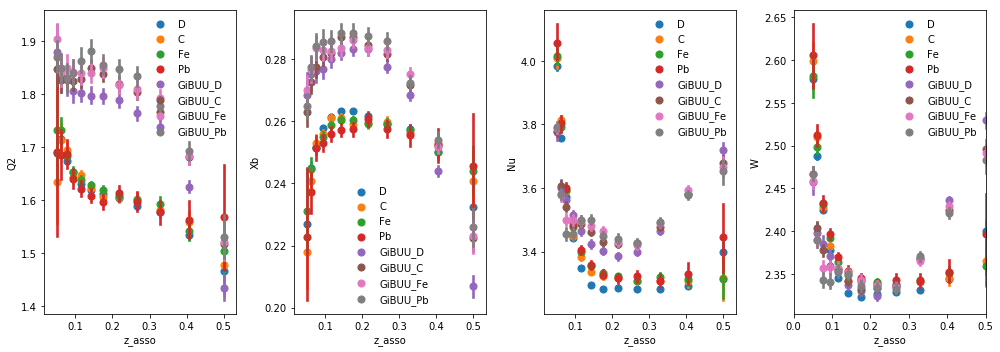

In [13]:
fig = plt.figure( figsize=(14, 5))

for ivar,variable in enumerate(['Q2','Xb','Nu','W']):
    plt.subplot(1,4,ivar+1)                                       
    for i, target in enumerate(['D','C','Fe','Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
    
    for i, target in enumerate(['GiBUU_D','GiBUU_C','GiBUU_Fe','GiBUU_Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
   
    
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.tight_layout()
plt.savefig('ProfilePlots_1.png')
plt.show()

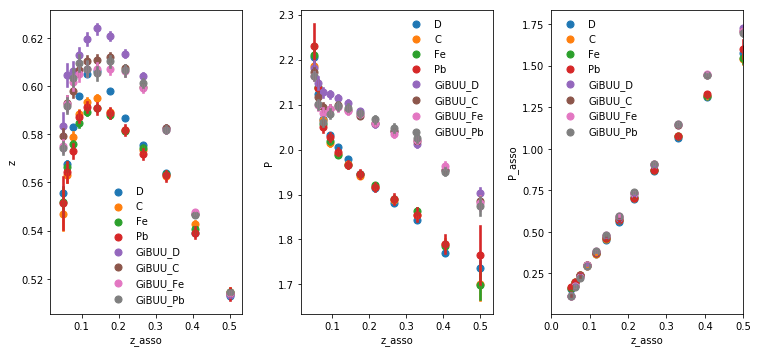

In [14]:
fig = plt.figure( figsize=(14, 5))

for ivar,variable in enumerate(['z','P','P_asso']):
    plt.subplot(1,4,ivar+1)                                       
    for i, target in enumerate(['D','C','Fe','Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
    
    for i, target in enumerate(['GiBUU_D','GiBUU_C','GiBUU_Fe','GiBUU_Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
   
    
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.tight_layout()
plt.savefig('ProfilePlots_2.png')
plt.show()

In [ ]:


                               
for ivar,variable in enumerate(['xf','xf_asso','y','y_asso','dy']):  
    plt.subplot(1,5,ivar+1)                   

    for i, target in enumerate(['D','C','Fe','Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.tight_layout()
plt.savefig('ProfilePlots_3.png')     
plt.clf() 
                               
for ivar,variable in enumerate(['mass','missing_mass','dipion_pt','dphi']): 
    plt.subplot(1,4,ivar+1)                   
    for i, target in enumerate(['D','C','Fe','Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.tight_layout()
plt.savefig('ProfilePlots_4.png')    
plt.clf() 
                               
           
for ivar,variable in enumerate(['phi_lab_asso','theta_lab_asso','phi_lab','theta_lab']): 
    plt.subplot(1,4,ivar+1)                   
    for i, target in enumerate(['D','C','Fe','Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.tight_layout()
plt.savefig('ProfilePlots_5.png')    

## plot for mixed events. In this case, key correlation should go away


## Profile plots but only for z1+z2<0.8

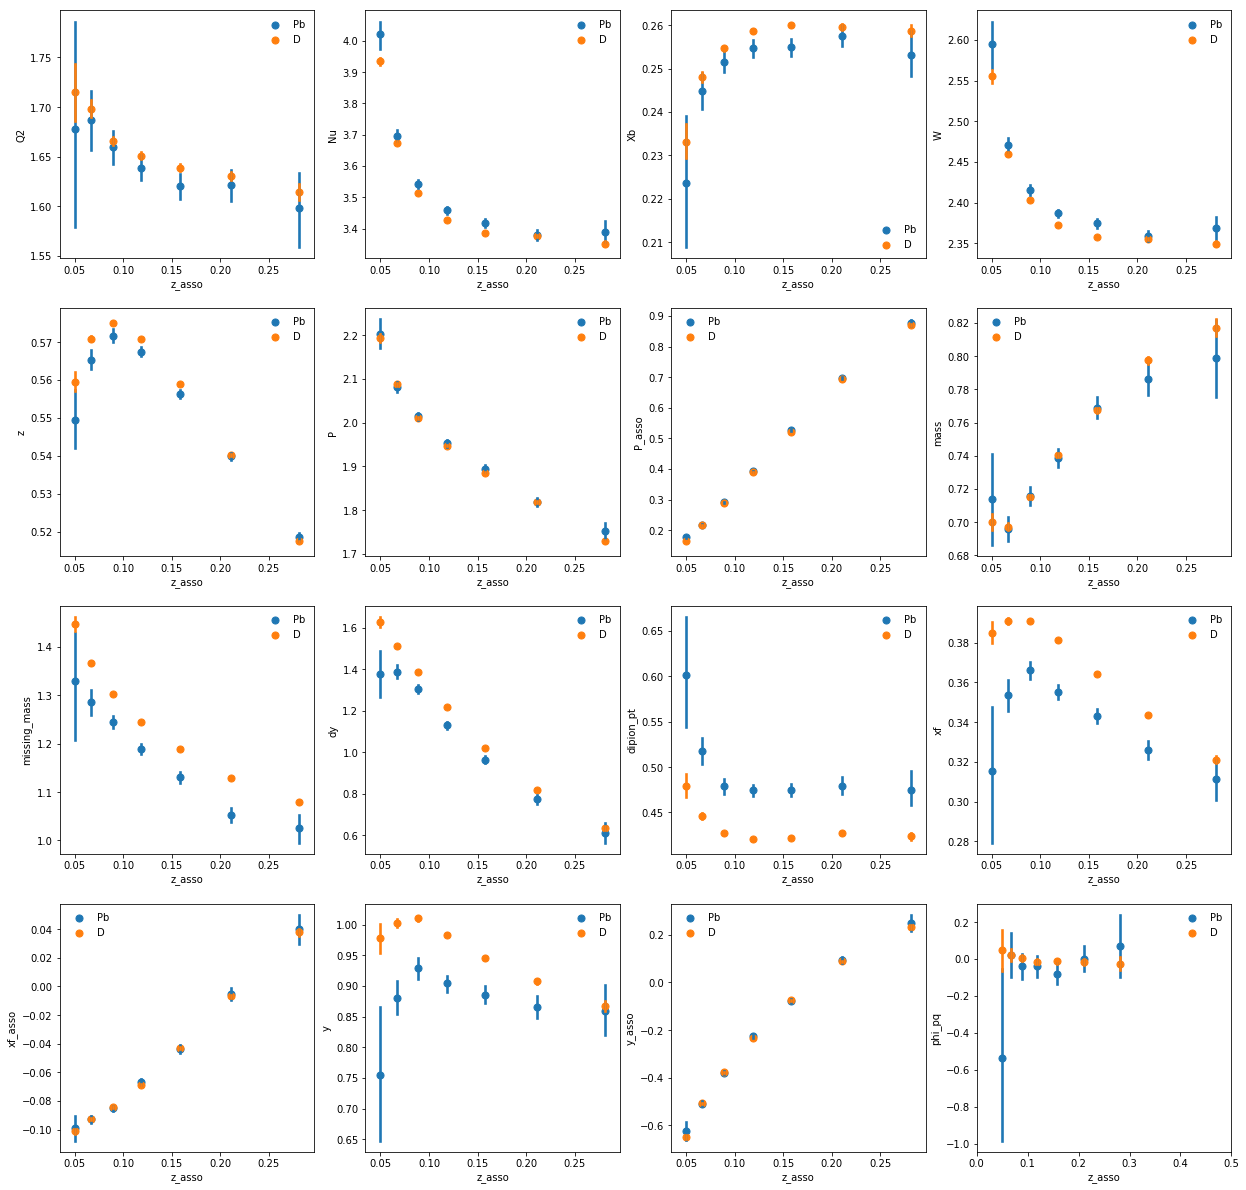

In [15]:
fig = plt.figure( figsize=(21, 21))

for ivar,variable in enumerate(['Q2','Nu','Xb','W','z','P','P_asso','mass','missing_mass','dy','dipion_pt','xf','xf_asso','y','y_asso','phi_pq']):
    plt.subplot(4,4,ivar+1)
    for i, target in enumerate(['Pb','D']):
        sns.regplot(x=df[target].query('z_tot<0.8')['z_asso'],y=df[target].query('z_tot<0.8')[variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),9),fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.savefig('ProfilePlots_withztotcut.png')

## invariant mass distribution

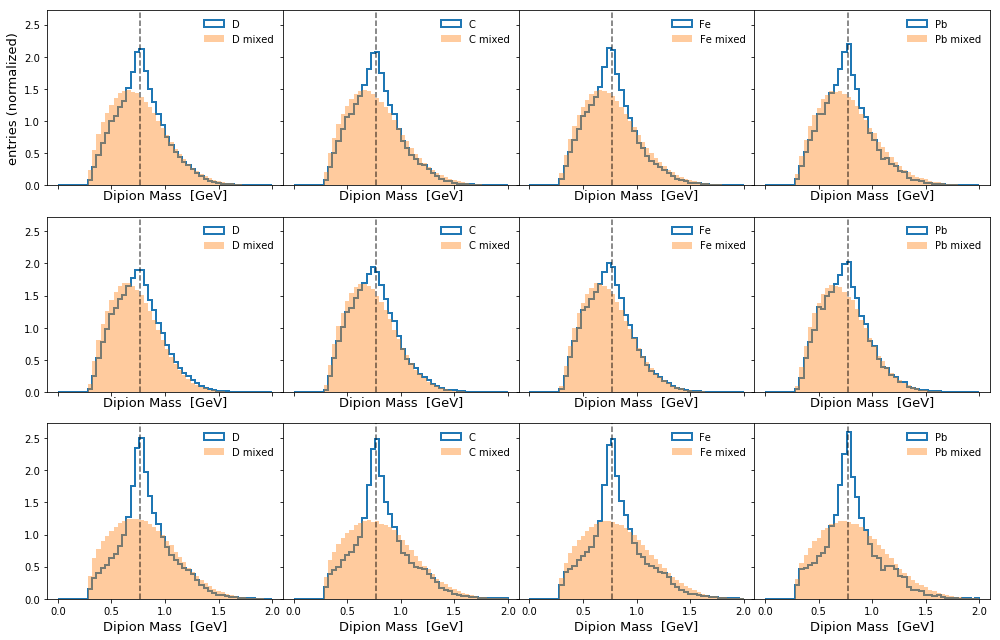

In [16]:
fig, axs = plt.subplots(3, 4,sharex=True, sharey=True,figsize=(14,9), gridspec_kw={'wspace':0})

for i, target in enumerate(['D','C','Fe','Pb']):
    axs[0,i].hist(df[target]['mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='%s'%target,linewidth=2.0)
    axs[0,i].hist(df['%s_mix'%target]['mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[0,i].axvline(x=0.770,linestyle='--',color='black',alpha=0.6)
    axs[0,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
    axs[0,i].legend(loc='best',frameon=False)

axs[0,0].yaxis.set_label_text("entries (normalized)", fontsize=13)


for i, target in enumerate(['D','C','Fe','Pb']):
    axs[1,i].hist(df[target].query('z_tot<0.8')['mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='%s'%target,linewidth=2.0)
    axs[1,i].hist(df['%s_mix'%target].query('z_tot<0.8')['mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[1,i].axvline(x=0.770,linestyle='--',color='black',alpha=0.6)
    axs[1,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
    axs[1,i].legend(loc='best',frameon=False)

for i, target in enumerate(['D','C','Fe','Pb']):
    axs[2,i].hist(df[target].query('z_tot>0.8')['mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='%s'%target,linewidth=2.0)
    axs[2,i].hist(df['%s_mix'%target].query('z_tot>0.8')['mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[2,i].axvline(x=0.770,linestyle='--',color='black',alpha=0.6)
    axs[2,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
    axs[2,i].legend(loc='best',frameon=False)

plt.tight_layout()
plt.savefig('Massforztotbins.png')    
                               

## Missing mas distribution

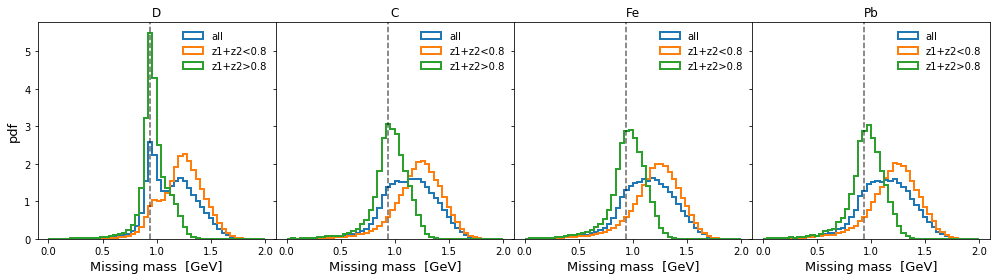

In [17]:
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(14,4), gridspec_kw={'wspace':0})

for i, target in enumerate(['D','C','Fe','Pb']):
    axs[i].hist(df[target]['missing_mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='all',linewidth=2.0)
    axs[i].hist(df[target].query('z_tot<0.8')['missing_mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='z1+z2<0.8',linewidth=2.0)
    axs[i].hist(df[target].query('z_tot>0.8')['missing_mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='z1+z2>0.8',linewidth=2.0)

    #axs[i].hist(df['%s_mix'%target]['missing_mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[i].axvline(x=0.938,linestyle='--',color='black',alpha=0.6)
    axs[i].xaxis.set_label_text("Missing mass  [GeV]", fontsize=13)
    axs[i].set_title(target)
    axs[i].legend(loc='best',frameon=False)

axs[0].yaxis.set_label_text("pdf", fontsize=13)


plt.tight_layout()
plt.savefig('MissingMassforztotbins.png')    

## Z and z_asso distributions without z1+z2 selection

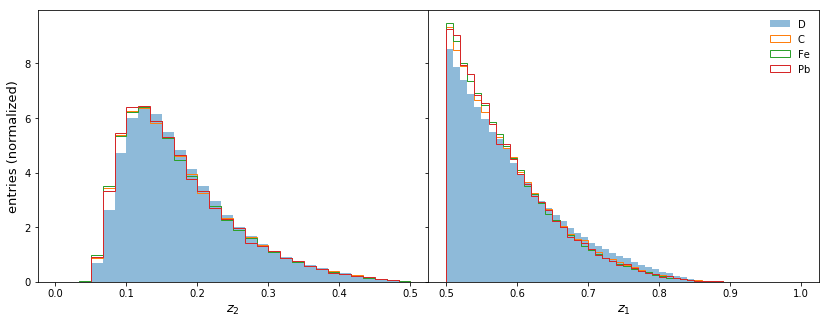

In [18]:
fig, axs = plt.subplots(1, 2,sharey=True,figsize=(14,5), gridspec_kw={'wspace':0})

axs[0].hist(df['D']['z_asso'], bins=30,range =(0,0.5), normed=True,label='D',alpha=0.5)

for i, target in enumerate(['C','Fe','Pb']):
    axs[0].hist(df[target]['z_asso'], bins=30,range =(0,0.5), histtype='step', normed=True,label=[target])
    
axs[1].hist(df['D']['z'], bins=50,range =(0.5,1.0), normed=True,label='D',alpha=0.5)
for i, target in enumerate(['C','Fe','Pb']):
    axs[1].hist(df[target]['z'], bins=50,range =(0.5,1.0), histtype='step', normed=True,label=[target]) 
 

axs[0].xaxis.set_label_text("$z_{2}$", fontsize=13)
axs[1].xaxis.set_label_text("$z_{1}$", fontsize=13)
axs[0].yaxis.set_label_text("entries (normalized)", fontsize=13)

plt.legend(loc='best',frameon=False)

plt.savefig('Zdistributions_all.png')    

## Z and z_asso distributions for z1+z2<0.8

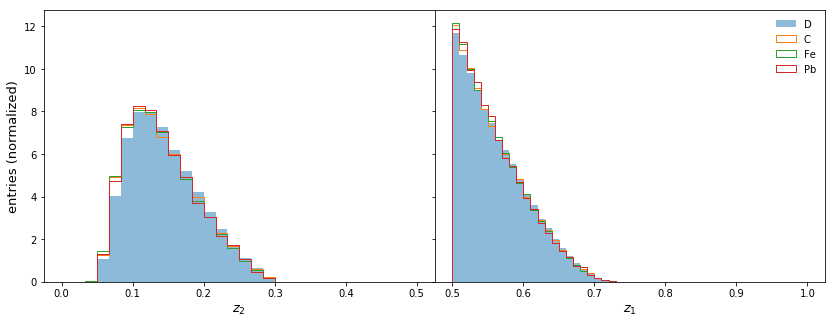

In [19]:
fig, axs = plt.subplots(1, 2,sharey=True,figsize=(14,5), gridspec_kw={'wspace':0})

axs[0].hist(df['D'].query('z_tot<0.8')['z_asso'], bins=30,range =(0,0.5), normed=True,label='D',alpha=0.5)

for i, target in enumerate(['C','Fe','Pb']):
    axs[0].hist(df[target].query('z_tot<0.8')['z_asso'], bins=30,range =(0,0.5), histtype='step', normed=True,label=[target])
    
axs[1].hist(df['D'].query('z_tot<0.8')['z'], bins=50,range =(0.5,1.0), normed=True,label='D',alpha=0.5)
for i, target in enumerate(['C','Fe','Pb']):
    axs[1].hist(df[target].query('z_tot<0.8')['z'], bins=50,range =(0.5,1.0), histtype='step', normed=True,label=[target]) 
 

axs[0].xaxis.set_label_text("$z_{2}$", fontsize=13)
axs[1].xaxis.set_label_text("$z_{1}$", fontsize=13)
axs[0].yaxis.set_label_text("entries (normalized)", fontsize=13)

plt.legend(loc='best',frameon=False)
plt.savefig('Zdistributions_cut.png')    

## Angular distributions phi_lab eta_lab for all z2 ranges

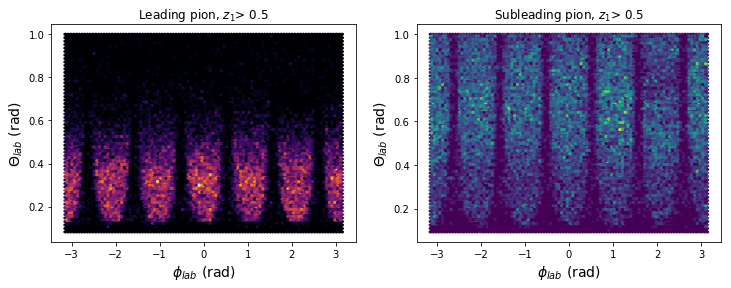

In [20]:
fig = plt.figure( figsize=(12, 4))

plt.subplot(1,2,1)
plt.hexbin(df['Pb']['phi_lab'],df['Pb']['theta_lab'],cmap='inferno')
plt.xlabel("$\phi_{lab}$ (rad)", fontsize=14)
plt.ylabel("$\Theta_{lab}$ (rad) ", fontsize=14)
plt.title('Leading pion, $z_{1}$> 0.5')

plt.subplot(1,2,2)
plt.hexbin(df['Pb']['phi_lab_asso'],df['Pb']['theta_lab_asso'],cmap='viridis')
plt.xlabel("$\phi_{lab}$ (rad)", fontsize=14)
plt.ylabel("$\Theta_{lab}$ (rad) ", fontsize=14)
plt.title('Subleading pion, $z_{1}$> 0.5')

plt.savefig('Angles_leadingandsubleading.png')    



## angles for z1 for various z2 bins

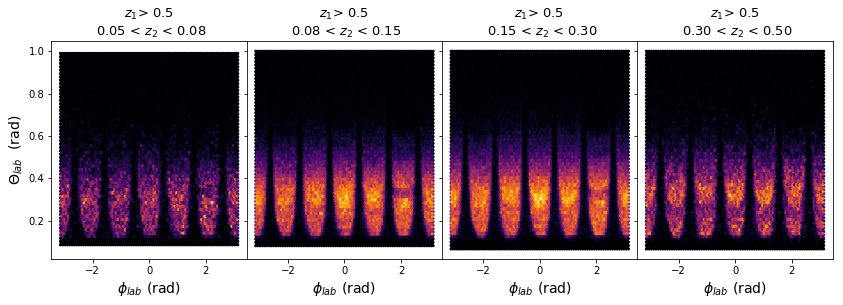

In [21]:
fig = plt.figure( figsize=(12, 12))

fig, axs = plt.subplots(1, 4,figsize=(14,4),sharey=True,sharex=True, gridspec_kw={'wspace':0, 'hspace':0})


asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f and theta_lab<1.0'%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    query = query_trigger + ' and ' + query_asso
    #plt.subplot(3,3,j+1)
    axs[j].hexbin(df['D'].query(query)['phi_lab'],df['D'].query(query)['theta_lab'],cmap='inferno')
    axs[j].xaxis.set_label_text("$\phi_{lab}$ (rad)", fontsize=14)
    axs[0].yaxis.set_label_text("$\Theta_{lab}$  (rad)", fontsize=14)
    axs[j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    

plt.savefig('z1LabAngles_z2bins_allpions.png')    
plt.show()

## Angle for z2 in different bins

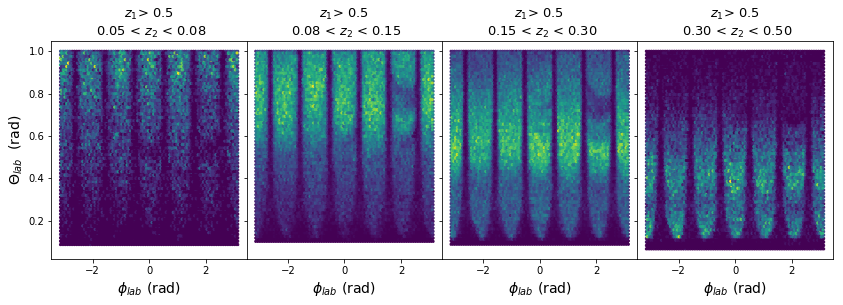

In [22]:
fig = plt.figure( figsize=(12, 12))

fig, axs = plt.subplots(1, 4,figsize=(14,4),sharey=True,sharex=True, gridspec_kw={'wspace':0, 'hspace':0})


asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    #plt.subplot(3,3,j+1)
    axs[j].hexbin(df['D'].query(query_asso)['phi_lab_asso'],df['D'].query(query_asso)['theta_lab_asso'],cmap='viridis')
    axs[j].xaxis.set_label_text("$\phi_{lab}$ (rad)", fontsize=14)
    axs[0].yaxis.set_label_text("$\Theta_{lab}$  (rad)", fontsize=14)
    axs[j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    

plt.savefig('LabAngles_z2bins_allpions.png')    
plt.show()

## Same as above but separately for pi+ and pi- of associated hadron

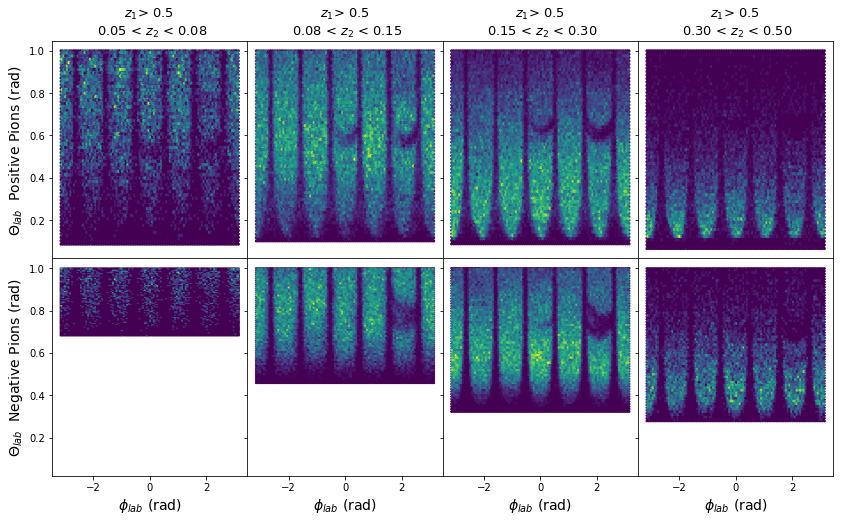

In [23]:
fig = plt.figure( figsize=(12, 12))

fig, axs = plt.subplots(2, 4,figsize=(14,8),sharey=True,sharex=True, gridspec_kw={'wspace':0, 'hspace':0})


asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    axs[0,j].hexbin(df['D'].query(query_asso + ' and pid_asso>0')['phi_lab_asso'],df['D'].query(query_asso + ' and pid_asso>0')['theta_lab_asso'],cmap='viridis')
    axs[1,j].hexbin(df['D'].query(query_asso + ' and pid_asso<0')['phi_lab_asso'],df['D'].query(query_asso + ' and pid_asso<0')['theta_lab_asso'],cmap='viridis')
    axs[1,j].xaxis.set_label_text("$\phi_{lab}$ (rad)", fontsize=14)
    axs[0,0].yaxis.set_label_text("$\Theta_{lab}$  Positive Pions (rad)", fontsize=14)
    axs[1,0].yaxis.set_label_text("$\Theta_{lab}$  Negative Pions (rad)", fontsize=14)
    axs[0,j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

plt.savefig('LabAngles_z2bins_piplusminus.png')    

plt.show()

## dphi_lab vs phi_lab for same-event and mixed-events

In [24]:
def plotacceptance(df,df_mix,title='',lab=True):
    if(lab==True):
        var1 = 'phi_lab'
        var1_asso = 'phi_lab_asso'
        var2 = 'dphi_lab'
        label = 'lab'
    else:
        var1 = 'phi_pq'
        var1_asso = 'phi_pq_asso'
        var2 = 'dphi'
        label ='PQ'
    fig = plt.figure( figsize=(12, 9))
    plt.subplot(2,3,1)
    plt.title(title)
    plt.hexbin(df[var1],df[var2],cmap='inferno',gridsize=25)
    plt.xlabel("$\phi_{%s}$ (rad)"%label, fontsize=14)
    plt.ylabel("$|d\phi_{%s}|$ (rad) "%label, fontsize=14)

    plt.subplot(2,3,2)
    plt.hist(df[var1],bins=100,label='z1',alpha=0.5)
    plt.hist(df[var1_asso],bins=100,label='z2',alpha=0.5)
    plt.legend(loc='best',frameon=False)

    plt.xlabel("$\phi_{%s}$ (rad)"%label, fontsize=14)
    plt.title(title)

    plt.subplot(2,3,3)
    plt.hist(df[var2],bins=50)
    plt.xlabel("$|d\phi_{%s}|$ (rad)"%label, fontsize=14)
    plt.title(title)
    #mixed events
    plt.subplot(2,3,4)
    plt.hexbin(df_mix[var1],df_mix[var2],cmap='inferno',gridsize=25)
    plt.xlabel("$\phi_{%s}$ (rad)"%label, fontsize=14)
    plt.ylabel("$|d\phi_{%s}|$ (rad)"%label, fontsize=14) 
    #plt.title(title)

    plt.subplot(2,3,5)
    plt.hist(df_mix[var1],bins=100,label='z1',alpha=0.5)
    plt.hist(df_mix[var1_asso],bins=100,label='z2',alpha=0.5)
    plt.legend(loc='best',frameon=False)
    plt.xlabel("$\phi_{%s}$ (rad)"%label, fontsize=14)
    #plt.title(title)

    plt.subplot(2,3,6)
    plt.hist(df_mix[var2],bins=50)
    plt.xlabel("$|d\phi_{%s}|$ (rad)"%label, fontsize=14)
    #plt.title(title)

    plt.show()


## Example for 0.1<z2 < 0.2 for both lab and pq frames

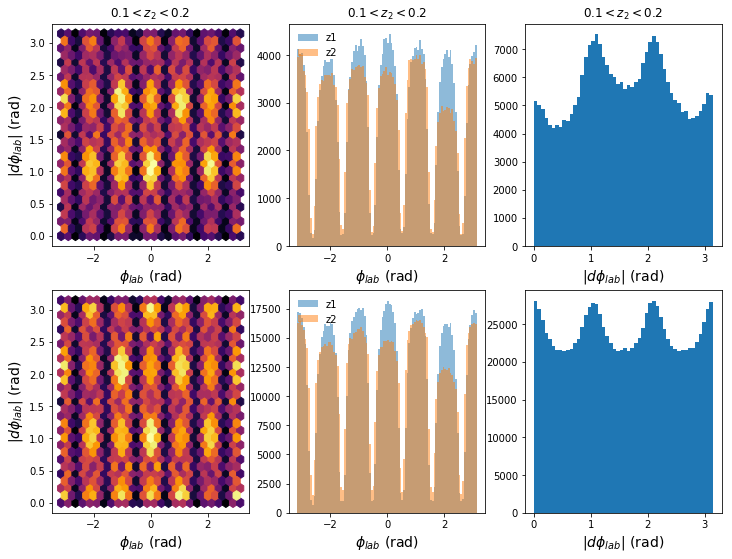

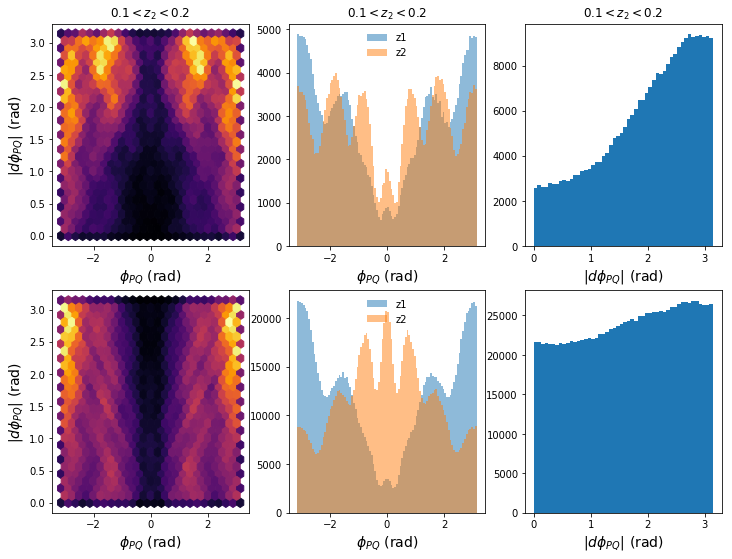

In [25]:
plotacceptance(df['D'].query('z_asso>0.1 and z_asso<0.2'),df['D_mix'].query('z_asso>0.1 and z_asso<0.2'),title='$0.1<z_2 <0.2$')
plotacceptance(df['D'].query('z_asso>0.1 and z_asso<0.2'),df['D_mix'].query('z_asso>0.1 and z_asso<0.2'),title='$0.1<z_2 <0.2$',lab=False)

## dphi_pq vs phi_pq for same-event and mixed-events

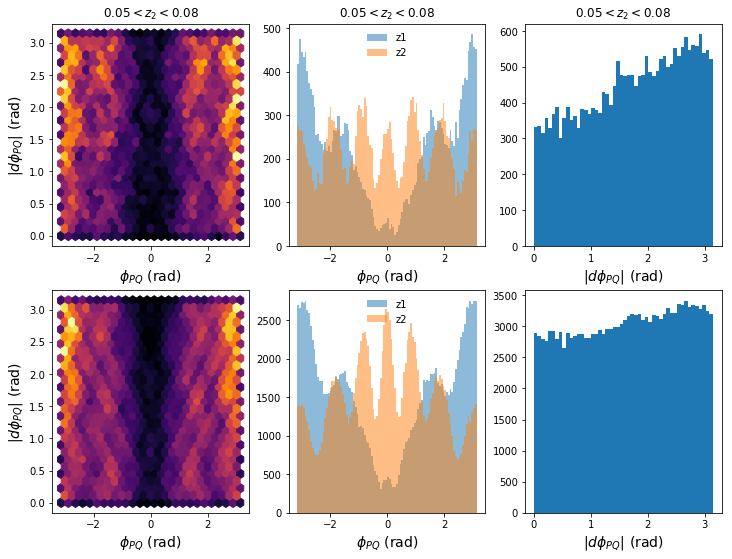

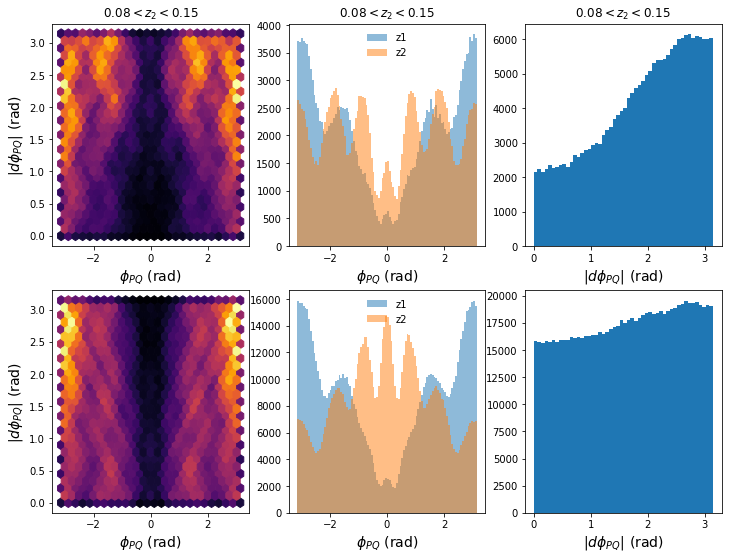

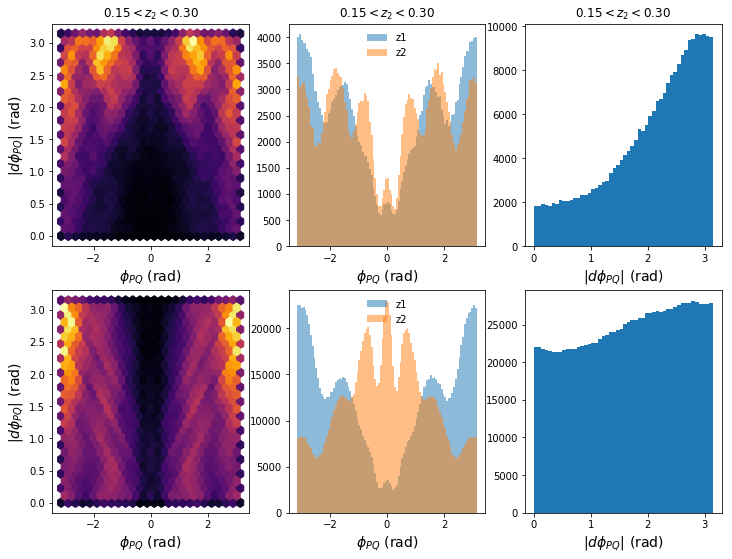

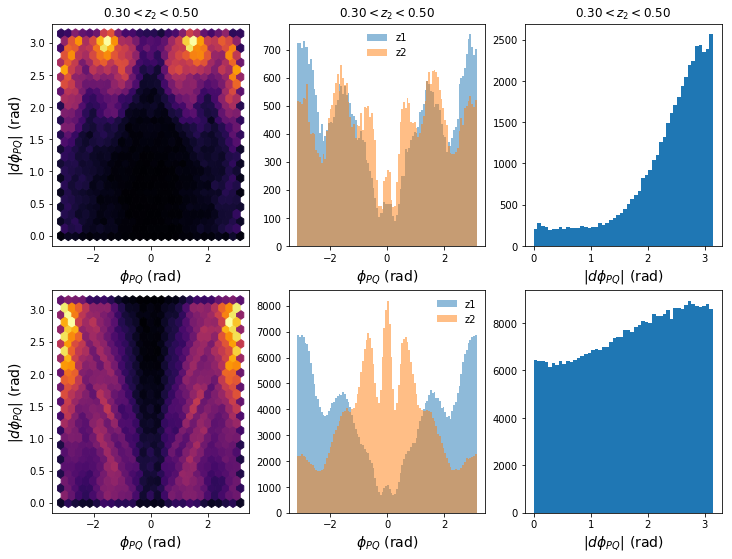

In [26]:
asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1]) 
    label =  '$%2.2f<z_2<%2.2f$'%(asso_bin[0],asso_bin[1]) 
    plotacceptance(df['D'].query(query_asso),df['D_mix'].query(query_asso),title=label,lab=False)

## z1 vs angles in lab / z2 vs angles in lab


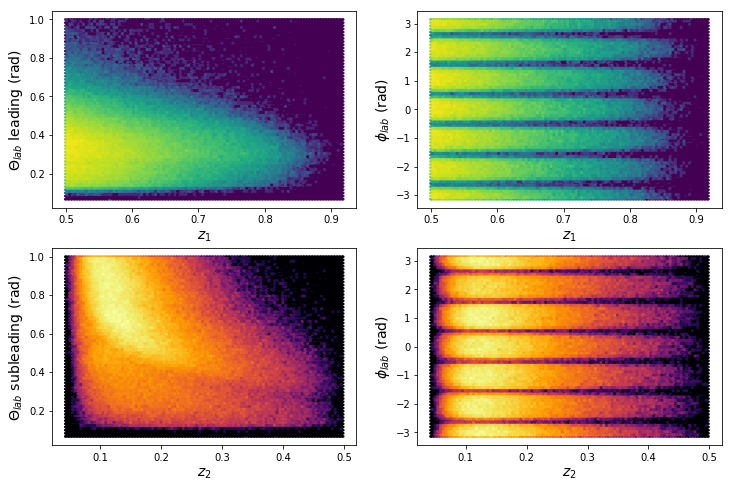

In [27]:
fig = plt.figure( figsize=(12, 8))
plt.subplot(2,2,1)
plt.hexbin(df['D']['z'],df['D']['theta_lab'], bins='log',cmap='viridis')
plt.xlabel("$z_{1}$", fontsize=14)
plt.ylabel("$\Theta_{lab}$ leading (rad) ", fontsize=14)

plt.subplot(2,2,2)
plt.hexbin(df['D']['z'],df['D']['phi_lab'], bins='log',cmap='viridis')
plt.xlabel("$z_{1}$", fontsize=14)
plt.ylabel("$\phi_{lab}$ (rad) ", fontsize=14)

plt.subplot(2,2,3)
plt.hexbin(df['D']['z_asso'],df['D']['theta_lab_asso'], bins='log',cmap='inferno')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$\Theta_{lab}$ subleading (rad) ", fontsize=14)

plt.subplot(2,2,4)
plt.hexbin(df['D']['z_asso'],df['D']['phi_lab_asso'], bins='log',cmap='inferno')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$\phi_{lab}$ (rad) ", fontsize=14)


plt.savefig('CorrelationAnglesandz1z2.png')    


## Same as above but sorted for pions of positive or negative charge

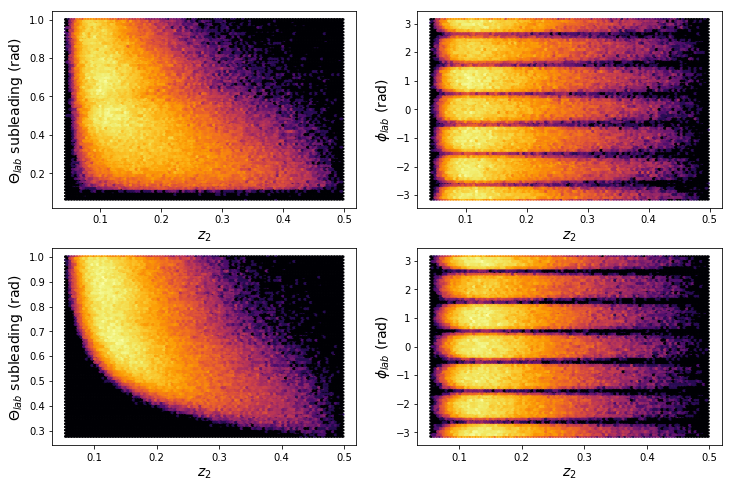

In [28]:
fig = plt.figure( figsize=(12, 8))
plt.subplot(2,2,1)
plt.hexbin(df['D'].query('pid_asso>0')['z_asso'],df['D'].query('pid_asso>0')['theta_lab_asso'], bins='log',cmap='inferno')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$\Theta_{lab}$ subleading (rad) ", fontsize=14)

plt.subplot(2,2,2)
plt.hexbin(df['D'].query('pid_asso>0')['z_asso'],df['D'].query('pid_asso>0')['phi_lab_asso'], bins='log',cmap='inferno')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$\phi_{lab}$ (rad) ", fontsize=14)

plt.subplot(2,2,3)
plt.hexbin(df['D'].query('pid_asso<0')['z_asso'],df['D'].query('pid_asso<0')['theta_lab_asso'], bins='log',cmap='inferno')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$\Theta_{lab}$ subleading (rad) ", fontsize=14)

plt.subplot(2,2,4)
plt.hexbin(df['D'].query('pid_asso<0')['z_asso'],df['D'].query('pid_asso<0')['phi_lab_asso'], bins='log',cmap='inferno')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$\phi_{lab}$ (rad) ", fontsize=14)


plt.savefig('CorrelationAnglesandz1z2.png')    
